In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pingouin as pg
from urllib.parse import urlencode
from scipy.stats import chi2_contingency

In [2]:
def yadisk_url(url):#Функция для считывания данных с Яндекс.Диска
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

# Получаем URL-адреса для скачивания файлов
path1 = yadisk_url('https://disk.yandex.ru/d/4XXIME4osGrMRA')
path2 = yadisk_url('https://disk.yandex.ru/d/yJFydMNNGkEKfg')
path3 = yadisk_url('https://disk.yandex.ru/d/br6KkQupzzTGoQ')
path4 = yadisk_url('https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
path5 = yadisk_url('https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
path6 = yadisk_url('https://disk.yandex.ru/d/th5GL0mGOc-qzg')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
df_users=pd.read_csv(path1,sep=';')
df_users_control1=pd.read_csv(path2,sep=';')
df_users_control2=pd.read_csv(path3,sep=';')
df_transactions=pd.read_csv(path4,sep=';')
df_transactions_control1=pd.read_csv(path5,sep=';')
df_transactions_control2=pd.read_csv(path6,sep=';')

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.
Необходимо проверить успешность эксперимента

> Успешность эксперимента - новые условия принесли больше подписок и прибыли по окончании пробного периода.  
т.е. в процессе работы с данными нам нужно определить страны выбранные для эксперимента, количество пользователей и прибыль компании для обеих групп после чего выяснить их соотношение\зависимость  
Объект исследования - premium_no_trial – премиум-подписка без пробной

посмотрим что за данные, сформируем несколько тезисов для дальнейшей работы

In [4]:
df_users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


uid – идентификатор пользователя  
age – возраст  
attraction_coeff – коэффициент привлекательности (от 0 до 1000, \frac{лайки}{просмотры}*1000 просмотры лайки∗1000)  
coins – число монеток (внутренняя валюта)  
country – страна    
visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)  
gender – пол  
age_filter_start  – фильтр поиска, мин. значение    
age_filter_end  – фильтр поиска, макс. значение   
views_count – число полученных оценок   
was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)  
is_premium –  является ли премиум  
total_revenue – нормированная выручка   

In [5]:
df_users.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [6]:
df_users.shape

(4308, 13)

In [7]:
df_users.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [8]:
df_users.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
mean,8.917437e+08,31.889276,316.411328,229.836735,0.953110,26.701486,38.248839,50.391133,1.0,1.0,534.080316
std,4.547670e+05,10.245287,323.373725,1205.819471,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4371.682632
min,8.910511e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.0,1.0,129870.000000


In [9]:
df_users.country.nunique()

51

In [10]:
duplicates = df_users.duplicated()
duplicates.sum()

0

total_revenue выглядит так странно потому что более 75% пользователей не приносят прибыль компании, при этом сейчас есть только 157 пользователей с премиумом на 4308 всех пользователей (у остальных как раз стоят NaN значения)

оставим тех пользователей, у которых был\есть премиум и они заплатили за него

In [11]:
df_u = df_users[~np.isnan(df_users['was_premium'])]
df_u.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0
13,891219699,30,1000,NaN,United States of America,NaN,1,27,33,1,1.0,NaN,0
20,891152790,29,769,NaN,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597
36,891348462,24,466,NaN,United States of America,NaN,1,16,36,15,1.0,NaN,0
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817


In [12]:
df_u=df_u.query('total_revenue != 0')
df_u.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
20,891152790,29,769,NaN,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817
100,891343671,26,0,24.0,France,"1,2,3,4,5,6,7,8,9",1,23,35,37,1.0,1.0,21580
105,892430988,28,181,NaN,United States of America,"1,2",1,25,31,22,1.0,1.0,12727
124,891347046,30,466,NaN,United Kingdom (Great Britain),"2,4,5,6,8",1,27,42,30,1.0,NaN,1261


In [13]:
df_u.shape

(140, 13)

In [14]:
df_u.country.unique()

array(['Spain', 'Italy', 'France', 'United States of America',
       'United Kingdom (Great Britain)', 'Belgium',
       'United Arab Emirates', 'Israel', 'Canada', 'Chile', 'Argentina',
       'Latvia', 'Turkey', 'Germany', 'Australia', 'Switzerland',
       'Mexico'], dtype=object)

In [15]:
df_u.country.nunique()

17

140 пользователей из 17 стран покупали премиум на данный момент согласно df_users  
сопоставим эти данные с df_transactions дабы убедиться в целостности предоставленных данных

In [16]:
df_transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


uid – идентификатор пользователя  
country – страна  
joined_at – дата и время регистрации  
paid_at – дата и время покупки  
revenue – нормированная выручка  
payment_id – идентификатор платежа  
from_page – откуда пользователь перешел на страницу оплаты  
product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)   

In [17]:
df_transactions.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [18]:
df_transactions.shape

(273, 8)

In [19]:
duplicates_t = df_transactions.duplicated()
duplicates_t.sum()

7

In [20]:
dup_t=df_transactions[df_transactions.duplicated(keep=False)]
dup_t

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
15,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
17,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
57,892339626,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754,19,empty_likes,coins
80,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
127,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins


In [21]:
df_transactions=df_transactions.drop_duplicates()

In [22]:
df_transactions.describe()

,uid,revenue,payment_id
count,2.660000e+02,266.000000,266.000000
mean,8.918302e+08,8767.766917,99.951128
std,3.775858e+05,11216.235341,57.409892
min,8.910712e+08,533.000000,0.000000
25%,8.914994e+08,3129.750000,19.000000
50%,8.918935e+08,6363.500000,146.000000
75%,8.920979e+08,12597.000000,147.000000
max,8.924386e+08,113477.000000,147.000000


In [23]:
df_transactions.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [24]:
df_transactions.revenue.sum()

2332226

In [25]:
df_users.total_revenue.sum()

2300818

выручка не совпадает, дубликаты из бд с транзакциями убраны, ищем "инвесторов"

In [26]:
df_transactions.payment_id.unique()

array([147,  67,  19, 146,  68,   0])

In [27]:
df_transactions.payment_id.value_counts()

147    125
19      74
146     30
67      22
68      14
0        1
Name: payment_id, dtype: int64

In [28]:
df_transactions.query('payment_id == 0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
220,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217,0,none,premium_no_trial


очень странная транзакция под payment_id = 0; кажется 67-68 и 146-147 пары старых\новых видов оплаты, виды 19 и 0 основные\тестовые?

In [29]:
df_transactions.from_page.unique()

array(['trial_vip_popup', 'menu', 'autoreply_message',
       'left_sidebar_menu', 'autorefill', 'ad_to_photo', 'gifts', 'none',
       'promo_09', 'super_popup', 'empty_likes', 'empty_mutual',
       'popular_users_chat', 'send_message', 'coins_popup',
       'popular_users_block', 'sympathy', 'delivery_vip', 'fans',
       'dating', 'user_profile', 'likes'], dtype=object)

In [30]:
df_transactions.product_type.unique()

array(['trial_premium', 'other_type', 'premium_no_trial', 'coins'],
      dtype=object)

получается у пользователя есть несколько способов получения премиума - прямая транзакция,внутриигровая валюта и other_type?

In [31]:
count = df_transactions[df_transactions['product_type'] == 'premium_no_trial'].shape[0]
count

76

In [32]:
count = df_transactions[df_transactions['country'] == 'United Arab Emirates'].shape[0]
count

12

In [33]:
df_t_pay_all=df_transactions.groupby('uid').agg({'revenue':'sum'}).reset_index()
df_t_pay_all.shape

(146, 2)

по таблице транзакций у нас 146 человек принесли деньги компании

In [34]:
df_t_pay_all.head()

,uid,revenue
0,891071157,9100
1,891152790,12597
2,891174411,28080
3,891175326,897
4,891178380,129870


In [35]:
ids_question = df_t_pay_all[~df_t_pay_all['uid'].isin(df_u['uid'])]
ids_question

,uid,revenue
3,891175326,897
54,891632079,4537
83,891914322,741
84,891914511,1508
91,891999783,3783
130,892333656,897


In [36]:
ids_question.revenue.sum()

12363

In [37]:
2332226-12363 #где то еще неучтенные деньги?

2319863

пользователи что есть в таблице о транзакциях, но в общей таблице о них нет записей с прибылью 

In [38]:
id_qust = df_users[df_users['uid'].isin(ids_question['uid'])]
id_qust

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
35,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,NaN,NaN,897
280,891914511,30,500,4.0,Switzerland,1,1,18,43,2,NaN,NaN,1508
530,891914322,35,500,6.0,United States of America,"1,2,3,4,5,6,7,8,9",1,32,38,48,NaN,NaN,741
968,891999783,30,793,6.0,United States of America,"1,2,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20...",1,27,33,29,NaN,NaN,3783
2895,891632079,30,100,9.0,United States of America,"5,6",1,27,33,20,NaN,NaN,4537
3997,891175326,29,666,6.0,United States of America,"1,2,3,5,7",1,26,32,3,NaN,NaN,897


Возможно это пользователи-потеряшки - с отсутствием данных по покупке премиума, причем несколько из них довольно активны и имеют неплохой фидбек по привлекательности - т.е. есть все основания полагать, что на момент среза данных у них все же был\есть активный премиум аккаунт, мб тогда это повтор транзакций?

In [39]:
id_qust1 = df_transactions[df_transactions['uid'].isin(ids_question['uid'])]
id_qust1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
8,891999783,United States of America,2017-10-23 04:21:00,2017-10-23 06:13:00,1261,19,autorefill,coins
65,891999783,United States of America,2017-10-23 04:21:00,2017-10-23 06:12:00,1261,19,empty_likes,coins
75,891175326,United States of America,2017-08-11 06:41:00,2017-09-11 04:33:00,897,146,empty_likes,coins
116,891632079,United States of America,2017-10-30 17:14:00,2017-10-30 22:04:00,4537,19,sympathy,other_type
142,891914511,Switzerland,2017-10-24 23:15:00,2017-10-25 03:21:00,1508,146,empty_likes,coins
156,891914322,United States of America,2017-10-24 23:20:00,2017-10-24 23:23:00,741,146,menu,coins
157,891999783,United States of America,2017-10-23 04:21:00,2017-10-23 06:11:00,1261,19,empty_likes,coins
261,892333656,United States of America,2017-10-16 01:45:00,2017-10-16 01:49:00,897,146,empty_likes,coins


т.е. это подписка за внутриигровую валюту и что-то other_type... возможно тут имеет место быть возврат ведь у 891999783 идут три покупки за 3 минуты подряд и одна из них это вообще авторефил; так как нас интересуют только premium_no_trial, то можем не учитывать этих пользователей в дальнейшем

так как суммы прибыли в таблицах пока что не сходятся, а в наличии пропусков по обозначению оплаты премиума мы убедились, то предыдущий вывод о 140 пользователях внесших деньги может быть ошибочным\неполным

In [40]:
df_us=df_users.query('total_revenue != 0')
df_us.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
20,891152790,29,769,NaN,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597
35,892333656,50,436,4.0,United States of America,"1,2,3,4",1,47,53,126,NaN,NaN,897
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817
100,891343671,26,0,24.0,France,"1,2,3,4,5,6,7,8,9",1,23,35,37,1.0,1.0,21580
105,892430988,28,181,NaN,United States of America,"1,2",1,25,31,22,1.0,1.0,12727


In [41]:
df_us.shape#вот и всплыли те шестеро, что без отметки о покупке премиума

(146, 13)

откуда в транзакциях еще 31к у.е. в прибыли пока не понял

In [42]:
df_users.query('total_revenue < 0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [43]:
df_transactions.query('revenue < 0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type


записей о возвратах\выплатах нет, пропусков в графе с деньгами тоже, скорее всего различаются суммы приходящие от пользователей

In [44]:
df_users_t_rev=df_users[['uid','total_revenue']]

In [45]:
df_users_t_rev=df_users_t_rev.query('total_revenue!= 0')
df_users_t_rev.shape

(146, 2)

In [46]:
df_razn=df_t_pay_all.merge(df_users_t_rev, on='uid')
df_razn['razn']=df_razn['total_revenue']-df_razn['revenue']
df_razn.query('razn !=0')

,uid,revenue,total_revenue,razn
42,891508155,9165,10101,936
99,892050108,15119,16380,1261
117,892202526,1794,2691,897
124,892236423,86996,95823,8827
129,892275462,58968,14885,-44083
131,892339626,17004,17758,754


In [47]:
df_razn.razn.sum()#а вот и потерянные 31к у.е. между df_users и df_transactions

-31408

In [48]:
df_transactions.from_page.unique()#рефанд?

array(['trial_vip_popup', 'menu', 'autoreply_message',
       'left_sidebar_menu', 'autorefill', 'ad_to_photo', 'gifts', 'none',
       'promo_09', 'super_popup', 'empty_likes', 'empty_mutual',
       'popular_users_chat', 'send_message', 'coins_popup',
       'popular_users_block', 'sympathy', 'delivery_vip', 'fans',
       'dating', 'user_profile', 'likes'], dtype=object)

хочу посмотреть распределение доната 

In [49]:
df_transactions.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium


In [50]:
df_tr=df_transactions.groupby(['payment_id','product_type']).agg({'uid':'count','revenue':'sum'}).reset_index()
df_tr

,payment_id,product_type,uid,revenue
0,0,premium_no_trial,1,9217
1,19,coins,71,455923
2,19,other_type,3,49244
3,67,other_type,22,65858
4,68,other_type,2,45149
5,68,premium_no_trial,12,51025
6,146,coins,30,105144
7,147,premium_no_trial,63,750464
8,147,trial_premium,62,800202


In [51]:
#plt.pie(df_tr.uid, labels=df_tr.product_type, autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7fcdb9c6cc88>,
 [Text(0.4059031278264971, 1.0223710925200626, 'coins'),
  Text(-0.9966333603572078, 0.4655340428186751, 'other_type'),
  Text(-0.7823969868694216, -0.7732108088598156, 'premium_no_trial'),
  Text(0.8180387170765486, -0.7353996582564848, 'trial_premium')],
 [Text(0.2214017060871802, 0.5576569595563977, '38.0%'),
  Text(-0.543618196558477, 0.2539276597192773, '10.2%'),
  Text(-0.42676199283786626, -0.4217513502871721, '28.6%'),
  Text(0.4462029365872083, -0.40112708632171895, '23.3%')])

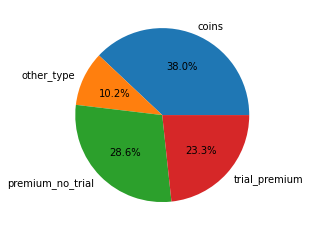

In [52]:
a=df_tr.groupby('product_type').agg({'uid':'sum','revenue':'sum'}).reset_index()

plt.pie(a.uid, labels=a.product_type, autopct='%1.1f%%')

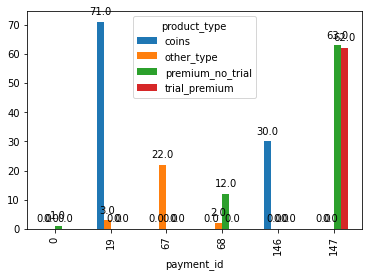

In [53]:
grouped = df_tr.groupby(['payment_id', 'product_type']).sum()

ax = grouped['uid'].unstack().plot(kind='bar')

# Добавление подписей к столбцам
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(title='product_type')

пока не сообразил как сделать это красивее   
тип транзакции 0 выглядит как какая то ошибка

================================================================================================

посмотрим что с группами

In [54]:
df_users_control1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [55]:
df_users_control1.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [56]:
df_users_control2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [57]:
df_users_control2.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

как и в тестовых df видим наличие пропусков и выбивающиеся типы данных.

In [58]:
df_users_control1.query('total_revenue != 0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
5,891497961,28,400,28.0,Chile,"1,2",1,25,31,25,NaN,NaN,6396
107,892380033,29,535,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,31,142,1.0,1.0,4732
174,891292845,22,0,NaN,Italy,NaN,1,19,40,0,1.0,1.0,1898
181,892336797,24,255,NaN,United States of America,"1,6,7,9,10,11,13,14",1,21,27,43,1.0,NaN,6292
187,891264903,19,239,NaN,United States of America,"2,3,4,5,6,7,8,9",1,16,22,46,1.0,1.0,7761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209,891174534,49,0,NaN,Argentina,NaN,1,46,52,0,1.0,1.0,10517
4214,891131061,23,192,NaN,Chile,"1,2,3,4,5,6",1,20,26,52,1.0,1.0,10075
4231,891543996,50,508,NaN,United States of America,NaN,1,26,53,120,1.0,1.0,6292
4246,892145004,27,866,NaN,Chile,"4,5,6,7",1,24,40,15,1.0,1.0,9919


In [59]:
df_users_control2.query('total_revenue != 0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
5,892197879,28,71,NaN,Italy,1,1,25,31,14,NaN,NaN,2522
20,892164795,16,0,NaN,France,NaN,1,16,20,0,1.0,1.0,16562
25,892343331,30,1000,NaN,France,1,1,27,99,1,1.0,NaN,2873
47,891668253,35,189,14.0,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17",1,24,38,190,1.0,1.0,20085
70,892318245,33,143,32.0,United Kingdom (Great Britain),"1,2,3,4",1,24,50,202,1.0,1.0,22685
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,892186737,30,250,NaN,Chile,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,27,33,8,1.0,1.0,4732
4182,891333651,34,0,NaN,France,"2,3,4",1,31,37,0,NaN,NaN,1456
4190,891452592,49,127,NaN,France,"1,2,3,4,5,6,7,8,9,10,11,12",1,39,48,837,1.0,1.0,15626
4233,891213609,26,363,NaN,United States of America,NaN,1,23,29,11,1.0,1.0,6292


количество пользователей, принесших прибыль компании в группах примерно одинаково, предварительно сравним прибыль
df_users.total_revenue.sum() = 2300818

In [60]:
df_u_c1_total=df_users_control1.query('total_revenue != 0')
df_u_c1_total=df_u_c1_total.total_revenue.sum()
df_u_c1_total

2581267

In [61]:
df_u_c2_total=df_users_control2.query('total_revenue != 0')
df_u_c2_total=df_u_c2_total.total_revenue.sum()
df_u_c2_total

1920438

In [62]:
(df_u_c1_total+df_u_c2_total)/2

2250852.5

разница между группами значительна, а среднее меньше значения тестового, даже с учетом потерянных 30к у.е.  
посмотрим что там с транзакциями

In [63]:
df_transactions_control1.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [64]:
df_transactions_control1.dtypes

uid             float64
country          object
joined_at        object
paid_at          object
revenue         float64
payment_id      float64
from_page        object
product_type     object
dtype: object

In [65]:
df_transactions_control1.isna().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [66]:
df_transactions_control1.describe()

,uid,revenue,payment_id
count,3.770000e+02,377.000000,377.000000
mean,8.923612e+08,6929.206897,91.145889
std,6.162900e+06,8027.889630,58.599773
min,8.910923e+08,26.000000,0.000000
25%,8.913833e+08,2730.000000,19.000000
50%,8.918225e+08,6266.000000,127.000000
75%,8.921850e+08,6448.000000,147.000000
max,9.609370e+08,63037.000000,147.000000


In [67]:
df_transactions_control1.shape

(1007, 8)

In [68]:
df_transactions_control2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [69]:
df_transactions_control2.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [70]:
df_transactions_control2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [71]:
df_transactions_control2.describe()

,uid,revenue,payment_id
count,3.280000e+02,328.000000,328.000000
mean,8.918121e+08,5854.993902,95.527439
std,3.802149e+05,6582.242539,57.247832
min,8.910681e+08,481.000000,0.000000
25%,8.915738e+08,2323.750000,19.000000
50%,8.918626e+08,4706.000000,146.000000
75%,8.921281e+08,6314.750000,147.000000
max,8.924388e+08,81796.000000,147.000000


In [72]:
df_transactions_control2.shape

(328, 8)

In [73]:
df_transactions_control1=df_transactions_control1.dropna()
df_transactions_control1.shape

(377, 8)

In [74]:
df_transactions_control1.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [75]:
df_transactions_control1['uid']=df_transactions_control1['uid'].astype('int')
df_transactions_control1['revenue']=df_transactions_control1['revenue'].astype('int')
df_transactions_control1['payment_id']=df_transactions_control1['payment_id'].astype('int')

In [76]:
#df_transactions_control1[['country', 'from_page', 'product_type']]=df_transactions_control1[['country', 'from_page', 'product_type']].apply(str.strip)
#df_transactions_control2[['country', 'from_page', 'product_type']]=df_transactions_control2[['country', 'from_page', 'product_type']].apply(str.strip)
#df_transactions_control1['country']=df_transactions_control1['country'].astype(str).str.strip()
#df_transactions_control1 = df_transactions_control1.astype({'country': str, 'from_page': str, 'product_type': str})
#df_transactions_control2 = df_transactions_control2.astype({'country': str, 'from_page': str, 'product_type': str})
#df_transactions_control1.country.apply(type)

In [77]:
df_transactions_control1[['joined_at','paid_at']]=df_transactions_control1[['joined_at','paid_at']].apply(pd.to_datetime)
df_transactions_control2[['joined_at','paid_at']]=df_transactions_control2[['joined_at','paid_at']].apply(pd.to_datetime)

In [78]:
df_transactions_control1.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [79]:
df_transactions_control2.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [80]:
df_tr_с1=df_transactions_control1.groupby(['payment_id','product_type']).agg({'uid':'count','revenue':'sum'}).reset_index()
df_tr_с1

,payment_id,product_type,uid,revenue
0,0,other_type,3,806
1,0,premium_no_trial,2,12714
2,19,coins,117,752479
3,19,other_type,4,5863
4,67,other_type,41,136890
5,68,other_type,2,37570
6,68,premium_no_trial,16,42822
7,127,other_type,5,7293
8,146,coins,32,119431
9,147,premium_no_trial,88,723723


In [81]:
df_tr_с2=df_transactions_control2.groupby(['payment_id','product_type']).agg({'uid':'count','revenue':'sum'}).reset_index()
df_tr_с2

,payment_id,product_type,uid,revenue
0,0,premium_no_trial,1,4719
1,19,coins,94,306137
2,19,other_type,1,1482
3,67,other_type,43,127257
4,68,premium_no_trial,14,70564
5,146,coins,30,96772
6,147,premium_no_trial,92,669526
7,147,trial_premium,53,643981


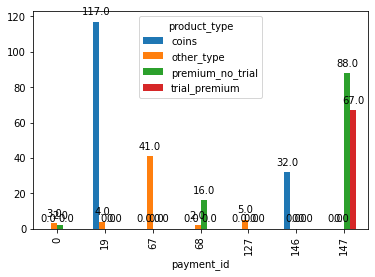

In [82]:
grouped_с1 = df_tr_с1.groupby(['payment_id', 'product_type']).sum()

ax = grouped_с1['uid'].unstack().plot(kind='bar')

# Добавление подписей к столбцам
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(title='product_type')

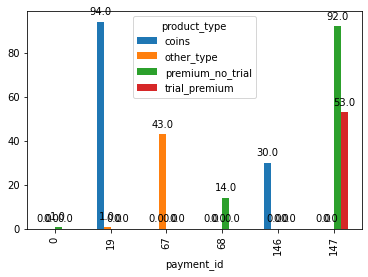

In [83]:
grouped_с2 = df_tr_с2.groupby(['payment_id', 'product_type']).sum()

ax = grouped_с2['uid'].unstack().plot(kind='bar')

# Добавление подписей к столбцам
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.legend(title='product_type')

значения покупки премиума без пробного периода (объект исследования) явно больше чем в тестовой группе, методы оплаты как ранее предполагали - 68 и 147. Так же можно отметить рост популярности покупки премиума через внутриигровую валюту - связано ли это с изменениями цены на премиум?

In [84]:
vozm_oshibki_tc1=df_transactions_control1.loc[df_transactions_control1['joined_at']>df_transactions_control1['paid_at']]
vozm_oshibki_tc2=df_transactions_control2.loc[df_transactions_control2['joined_at']>df_transactions_control2['paid_at']]

In [85]:
vozm_oshibki_tc1.shape

(55, 8)

In [86]:
vozm_oshibki_tc1.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
5,891721851,United States of America,2017-10-29 02:50:00,2017-05-11 07:15:00,4602,146,empty_likes,coins
14,892277877,United States of America,2017-10-17 03:36:00,2017-10-11 15:23:00,897,19,empty_likes,coins
20,892366260,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-09-11 20:06:00,6305,19,autorefill,coins


In [87]:
#vozm_oshibki_tc1.from_page.unique()
#vozm_oshibki_tc2.payment_id.unique()

In [88]:
vozm_oshibki_tc2.shape

(60, 8)

In [89]:
vozm_oshibki_tc2.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
14,891655107,United States of America,2017-10-30 05:06:00,2017-08-11 19:12:00,9087,147,trial_vip_popup,trial_premium


удалил пустые строки с df_transactions_control1, поправил типы данных, обнаружил наличие строк для которых оплата пришла раньше, чем пользователь зарегистрировался, и это ~1\6 всех данных, причем невозможно выделить какие то конкретные объекты ошибок - в них присутствуют все виды услуг, способы оплаты и страницы перехода


In [90]:
df_transactions_v_oshibki=df_transactions.loc[df_transactions['joined_at']>df_transactions['paid_at']]
df_transactions_v_oshibki.shape

(47, 8)

In [91]:
df_transactions.shape

(266, 8)

в тестовой группе так же обнаружены ошибки регистрации\оплаты, возможно это тоже является причиной различия сумм с df_users

In [92]:
df_transactions_v_oshibki.revenue.sum()

401752

In [93]:
df_transactions.revenue.sum()

2332226

In [94]:
df_users.total_revenue.sum()

2300818

как то уж слишком  много выходит

In [95]:
df_users.country.nunique()

51

In [96]:
q=set(df_users.country.unique())
w=set(df_users_control1.country.unique())
e=set(df_users_control2.country.unique())
qwe=q&w&e
qwe

{'Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'France',
 'Germany',
 'India',
 'Israel',
 'Italy',
 'Kyrgyzstan',
 'Mexico',
 'Peru',
 'Portugal',
 'Russian Federation',
 'Spain',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America'}

In [97]:
len(qwe)

25

>Промежуточные выводы: Первичный осмотр данных выявил наличие ошибок(не самые корректные типы данных; ошибки при обработке, приведшие к потери целостности данных), вопросы к достоверности некоторых данных (очень странное время транзакций и переходы к оплате, сами суммы). Возникает вопрос о видах доната в приложении - покупка через внутриигровую валюту премиума - это все же покупка премиума или? Основная платежная система через которую осуществляется покупка премиума напрямую 147 и 68. Страны для которых произошло изменение стоимости - примем те, что одинаковы для всех групп(25).  

на основе первичных выводов приступим к работе с данными: почистим и объединим df, сравним данные и посмотрим статистические параметры


In [98]:
df_users['grp']="test"
df_users_control1['grp']="c1"
df_users_control2['grp']="c2"

In [99]:
df_transactions['grp']="test"
df_transactions_control1['grp']="c1"
df_transactions_control2['grp']="c2"

In [100]:
users=pd.concat([df_users, df_users_control1, df_users_control2], axis=0).fillna(0)
users.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,grp
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test


In [101]:
users.shape

(12912, 14)

In [102]:
users=users[users['country'].isin(qwe)]
users.shape

(12828, 14)

In [103]:
users=users.drop_duplicates()

In [104]:
transactions=pd.concat([df_transactions, df_transactions_control1, df_transactions_control2], axis=0).fillna(0)
transactions.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,test


In [105]:
transactions.shape

(971, 9)

In [106]:
transactions=transactions[transactions['country'].isin(qwe)]
transactions.shape

(963, 9)

In [107]:
transactions=transactions.drop_duplicates()

В предыдущих шагах мы выявили ошибки с датами регистрации\оплаты, проверим - перекочевали ли они в общую таблицу

In [108]:
transactions.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
grp             object
dtype: object

In [109]:
transactions[['joined_at', 'paid_at']] = transactions[['joined_at', 'paid_at']].apply(pd.to_datetime)

In [110]:
transactions.sort_values('joined_at').head(5)#refund_WP??????????

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143,0,refund_WP,other_type,c1
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637,0,refung_AP,other_type,c1
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26,0,refund_VP,other_type,c1
342,891561825,France,2017-01-11 01:06:00,2017-01-11 13:33:00,3913,146,empty_likes,coins,c1
196,891561825,France,2017-01-11 01:06:00,2017-08-11 03:06:00,12636,147,trial_vip_popup,trial_premium,c1


наличие данных от 2015 года, еще и payment_id = 0, что скорее всего является тестовым для разработчиков приложения + строки с refund (которые не показывались в изначальной df_transactions!?!?) - удалим из df  
так же стоит вспомнить, что ранее мы находили строки, где оплата была произведена позже времени регистрации пользователя

In [111]:
transactions = transactions[transactions['joined_at'].dt.year != 2015]

In [112]:
bad_transactions = transactions[transactions['paid_at'] < transactions['joined_at']]
bad_transactions.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
11,891861048,Canada,2017-10-26 02:55:00,2017-10-11 19:00:00,3588,68,none,premium_no_trial,test
20,891806280,United States of America,2017-10-27 08:56:00,2017-03-11 10:57:00,8242,147,trial_vip_popup,trial_premium,test
24,891786216,Spain,2017-10-27 18:20:00,2017-03-11 20:20:00,12818,147,trial_vip_popup,trial_premium,test
25,892057347,France,2017-10-21 23:15:00,2017-08-11 01:56:00,1209,19,none,coins,test
36,891589239,Italy,2017-10-31 14:16:00,2017-09-11 15:44:00,6305,19,empty_likes,coins,test


In [113]:
bad_transactions.shape

(158, 9)

In [114]:
#bad_transactions['paid_at'] = bad_transactions['joined_at'] + pd.Timedelta(minutes=1)
#transactions.paid_at=transactions.paid_at.isin(bad_transactions.paid_at)
bat_tr = transactions['paid_at'] < transactions['joined_at']#булеваясерия для определения 
transactions.loc[bat_tr, 'paid_at'] = transactions.loc[bat_tr, 'joined_at'] + pd.Timedelta(seconds=1)#loc для выбора конкретных строк
#+1 секунда для наглядности
transactions[transactions['uid'] == 891861048]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
11,891861048,Canada,2017-10-26 02:55:00,2017-10-26 02:55:01,3588,68,none,premium_no_trial,test
23,891861048,Canada,2017-10-26 02:55:00,2017-10-28 16:30:00,3549,19,none,coins,test
208,891861048,Canada,2017-10-26 02:55:00,2017-10-26 16:05:00,3562,19,none,coins,test
234,891861048,Canada,2017-10-26 02:55:00,2017-10-26 03:00:00,3588,68,none,premium_no_trial,test
241,891861048,Canada,2017-10-26 02:55:00,2017-10-28 16:31:00,3549,67,none,other_type,test
245,891861048,Canada,2017-10-26 02:55:00,2017-10-26 02:55:01,3523,19,none,coins,test


In [115]:
transactions.shape #итого убрали 29 строк

(934, 9)

Так же стоит убрать строки, которые не участвовали в нашем эксперименте, а конкретнее все payment_id что != 147 и 68

In [116]:
transactions = transactions[(transactions['payment_id'] == 147) | (transactions['payment_id'] == 68)]
transactions.shape 

(468, 9)

In [117]:
transactions.product_type.unique()

array(['trial_premium', 'premium_no_trial', 'other_type'], dtype=object)

In [118]:
transactions = transactions[transactions['product_type'] == 'premium_no_trial']
transactions.shape 

(283, 9)

для работы с пользователями - оставим только тех, что удовлетворяют нашим условиям и прошли проверку по транзакциям

In [119]:
users.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,grp
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test


In [120]:
users.shape

(12828, 14)

In [121]:
selected_users = users[users['uid'].isin(transactions['uid'])]
selected_users.shape #в транзакциях оставались страны не из списка qwe??? или пользователь совершал несколько транзакций???

(266, 14)

In [122]:
#transactions[~transactions['country'].isin(qwe)] 
transactions.country.nunique()#их даже меньше

19

In [123]:
countryssssss = [i for i in qwe if i not in selected_users['country'].values]
countryssssss#страны что отпали из изначального списка 

['Colombia',
 'Dominican Republic',
 'Russian Federation',
 'Costa Rica',
 'Peru',
 'Kyrgyzstan']

In [124]:
transactions.uid.nunique()#есть пользователи с несколькими транзакицями по оплате премиум подписки

266

In [125]:
dup=transactions[transactions.duplicated(subset='uid', keep=False)]
dup.uid.unique()

array([891861048, 892339626, 892065108, 892261437, 892097937, 892393119,
       892366260, 892290105, 891264903, 891822480, 892139829, 892435536,
       891637005])

In [126]:
transactions[transactions['uid'] == 891861048 ]#это тот id что имел ошибку при регистрации в виде оплаты до -
#можно удалить первое вхождение

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
11,891861048,Canada,2017-10-26 02:55:00,2017-10-26 02:55:01,3588,68,none,premium_no_trial,test
234,891861048,Canada,2017-10-26 02:55:00,2017-10-26 03:00:00,3588,68,none,premium_no_trial,test


In [127]:
transactions = transactions.drop(transactions[(transactions['uid'] == 891861048) & (transactions['paid_at'] == '2017-10-26 02:55:01')].index)

In [128]:
transactions[transactions['uid'] == 892339626 ]#3 оплаты в разное время и разная сумма - оставим как есть

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
34,892339626,United States of America,2017-10-15 23:21:00,2017-10-29 07:51:00,2574,68,none,premium_no_trial,test
104,892339626,United States of America,2017-10-15 23:21:00,2017-11-11 01:05:00,2587,68,none,premium_no_trial,test
122,892339626,United States of America,2017-10-15 23:21:00,2017-10-17 18:58:00,2613,68,none,premium_no_trial,test


In [129]:
transactions[transactions['uid'] == 892065108 ]#здесь была ошибка регистрации\оплаты, причем для всех трех транзакций - удалю его вообще

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
38,892065108,France,2017-10-21 20:40:00,2017-10-21 20:40:01,7098,147,popular_users_chat,premium_no_trial,test
185,892065108,France,2017-10-21 20:40:00,2017-10-21 20:40:01,7098,147,popular_users_chat,premium_no_trial,test
213,892065108,France,2017-10-21 20:40:00,2017-10-21 20:40:01,7111,147,popular_users_chat,premium_no_trial,test


In [130]:
transactions = transactions.drop(transactions[transactions['uid'] == 892065108 ].index)

In [131]:
#df_transactions[df_transactions['uid'] == 892065108 ] проверял на возможный рефанд, но не понял откуда само значение рефанд 
#берется для from_page в df_transactions c 0 payment

In [132]:
transactions[transactions['uid'] == 892261437 ]#здесь была ошибка регистрации\оплаты, но сумма и даты разные, удалю ошибочное

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
56,892261437,Italy,2017-10-17 14:22:00,2017-10-17 14:22:01,1898,68,none,premium_no_trial,test
113,892261437,Italy,2017-10-17 14:22:00,2017-10-26 16:06:00,1937,68,none,premium_no_trial,test


In [133]:
transactions = transactions.drop(transactions[(transactions['uid'] == 892261437) & (transactions['paid_at'] == '2017-10-17 14:22:01')].index)

In [134]:
transactions[transactions['uid'] == 892097937 ]#3 оплаты в разное время и разная сумма - оставим как есть

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
79,892097937,Chile,2017-10-21 06:24:00,2017-10-31 03:22:00,8086,147,popular_users_chat,premium_no_trial,test
120,892097937,Chile,2017-10-21 06:24:00,2017-10-22 12:58:00,8216,147,popular_users_chat,premium_no_trial,test
171,892097937,Chile,2017-10-21 06:24:00,2017-10-23 13:56:00,8229,147,popular_users_chat,premium_no_trial,test


In [135]:
transactions[transactions['uid'] == 892393119 ]#здесь разница в минуту с одной суммой - 
#возможно ошибка оплаты и списание произошло дважды - удалю первое вхождение

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
42,892393119,Italy,2017-10-15 00:34:00,2017-10-21 13:10:00,1807,68,none,premium_no_trial,c1
141,892393119,Italy,2017-10-15 00:34:00,2017-10-21 13:09:00,1807,68,none,premium_no_trial,c1


In [136]:
transactions = transactions.drop(transactions[(transactions['uid'] == 892393119) & (transactions['paid_at'] == '2017-10-21 13:09:00')].index)

In [137]:
transactions[transactions['uid'] == 892366260 ]#оставим как есть - оплата была одинакова но в разные месяцы

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
84,892366260,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-10-15 15:49:00,6292,147,left_sidebar_menu,premium_no_trial,c1
103,892366260,United Kingdom (Great Britain),2017-10-15 15:04:00,2017-11-14 16:50:00,6292,147,left_sidebar_menu,premium_no_trial,c1


In [138]:
transactions[transactions['uid'] == 892290105 ]#оставим как есть

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
208,892290105,United States of America,2017-10-16 22:03:00,2017-10-21 22:30:00,4537,147,popular_users_block,premium_no_trial,c1
270,892290105,United States of America,2017-10-16 22:03:00,2017-10-23 12:50:00,6292,147,promo_09,premium_no_trial,c1


In [139]:
transactions[transactions['uid'] == 891264903 ]#оставим как есть, хотя есть вопрос к датам - 8й и 9й месяцы...

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
228,891264903,United States of America,2017-06-11 16:02:00,2017-08-11 22:32:00,3887,147,none,premium_no_trial,c1
351,891264903,United States of America,2017-06-11 16:02:00,2017-09-11 10:32:00,3874,147,none,premium_no_trial,c1


In [140]:
#transactions[transactions['paid_at'] < '2017-10-01' ] 73 клиента до октября

In [141]:
transactions.paid_at.min()

Timestamp('2017-01-11 05:16:00')

In [142]:
transactions.paid_at.max()

Timestamp('2017-12-11 15:23:00')

In [143]:
#grouped_per_month = transactions.groupby(transactions['paid_at'].dt.to_period('M')).apply(lambda x: x.sort_values('paid_at'))
#grouped_per_month

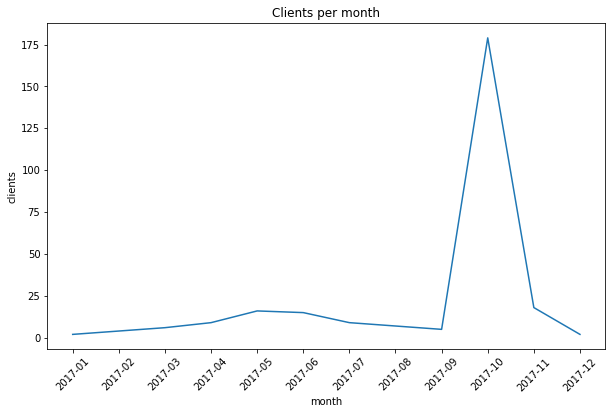

In [144]:
clients_per_month = transactions.groupby(transactions['paid_at'].dt.to_period('M')).size()
plt.figure(figsize=(10, 6))
plt.plot(clients_per_month.index.astype(str), clients_per_month.values)
plt.title('Clients per month')
plt.xlabel('month')
plt.ylabel('clients')
plt.xticks(rotation=45)
plt.show()

Новые системы оплаты были включены с начала 2017 года, но пик популярности пришелся на октябрь месяц... акции/реклама? за время проведения эксперимента возьмем весь 2017й год

In [145]:
transactions[transactions['uid'] == 891822480 ]#здесь была ошибка регистрации\оплаты, удалю ошибочное

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
245,891822480,Italy,2017-10-26 22:27:00,2017-10-27 23:29:00,1898,68,none,premium_no_trial,c1
262,891822480,Italy,2017-10-26 22:27:00,2017-10-26 22:27:01,6292,147,promo_09,premium_no_trial,c1


In [146]:
transactions = transactions.drop(transactions[(transactions['uid'] == 891822480) & (transactions['paid_at'] == '2017-10-26 22:27:01')].index)

In [147]:
transactions[transactions['uid'] == 892139829 ]#оставим так

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
13,892139829,United Kingdom (Great Britain),2017-10-20 08:38:00,2017-10-20 08:41:00,5135,147,autoreply_message,premium_no_trial,c2
196,892139829,United Kingdom (Great Britain),2017-10-20 08:38:00,2017-10-23 13:54:00,5161,147,promo_09,premium_no_trial,c2
247,892139829,United Kingdom (Great Britain),2017-10-20 08:38:00,2017-10-22 12:44:00,5161,147,promo_09,premium_no_trial,c2


In [148]:
transactions[transactions['uid'] == 892435536 ]#оставим так

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
29,892435536,United States of America,2017-10-14 02:54:00,2017-10-14 02:57:00,4537,147,dating,premium_no_trial,c2
195,892435536,United States of America,2017-10-14 02:54:00,2017-11-14 04:57:00,4537,147,dating,premium_no_trial,c2


In [149]:
transactions[transactions['uid'] == 891637005 ]#здесь была ошибка регистрации\оплаты, причем обе транзакции ошибочны, удалю вообще

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
279,891637005,Spain,2017-10-30 15:22:00,2017-10-30 15:22:01,6396,147,left_sidebar_menu,premium_no_trial,c2
292,891637005,Spain,2017-10-30 15:22:00,2017-10-30 15:22:01,6292,147,left_sidebar_menu,premium_no_trial,c2


In [150]:
index_to_drop = transactions[transactions['uid'] == 891637005].index[0]
transactions = transactions.drop(index_to_drop)

In [151]:
transactions.shape 

(269, 9)

In [152]:
selected_users = users[users['uid'].isin(transactions['uid'])]
selected_users.shape#убрал дубли транзакций

(259, 14)

посмотрим распределение пользователей

In [153]:
country_count=selected_users.groupby(['grp','country']).agg({'uid':'count'}).reset_index()
country_count.head()

,grp,country,uid
0,c1,Argentina,4
1,c1,Australia,1
2,c1,Belgium,1
3,c1,Canada,4
4,c1,Chile,4


In [154]:
country_count = pd.pivot_table(country_count, values='uid', index='country', columns='grp')

In [155]:
country_count.head()

grp,c1,c2,test
country,,,
Argentina,4.0,7.0,5.0
Australia,1.0,1.0,1.0
Belgium,1.0,5.0,1.0
Canada,4.0,1.0,3.0
Chile,4.0,6.0,4.0


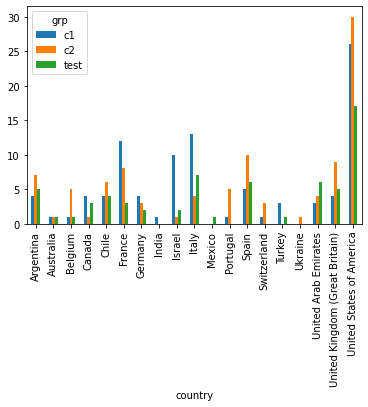

In [156]:
country_count.plot.bar()

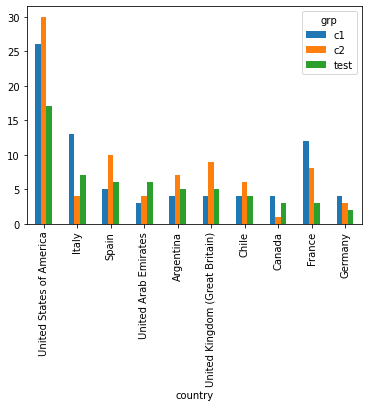

In [157]:
country_count.sort_values(['test'], ascending=False).head(10).plot.bar()#убрал мелкие + 
#обнаружил что не все группы имеют одинаковый список стран участников эксперимента

In [158]:
country_count=country_count.dropna()#убрал страны без наличия пользователей для каждой из групп
#думаю и в выборке стоит сделать так же

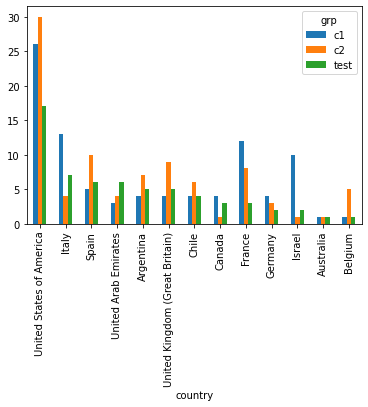

In [159]:
country_count.sort_values(['test'], ascending=False).plot.bar()

кажется тут есть различия в количестве уникальных клиентов, проверим это статистически

In [160]:
selected_users.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,grp
20,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,test
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,test
148,891806436,32,57,0.0,Italy,"1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19",1,20,35,69,1.0,1.0,12597,test


In [161]:
countrys=selected_users.groupby('country')['grp'].nunique()
countrys#удалю те страны, для которых нет клиентов во всех 3х группах

country
Argentina                         3
Australia                         3
Belgium                           3
Canada                            3
Chile                             3
France                            3
Germany                           3
India                             1
Israel                            3
Italy                             3
Mexico                            1
Portugal                          2
Spain                             3
Switzerland                       2
Turkey                            2
Ukraine                           1
United Arab Emirates              3
United Kingdom (Great Britain)    3
United States of America          3
Name: grp, dtype: int64

In [162]:
countrys3=countrys[countrys == 3].index #выбираю из списка только страны со значением 3 и сохраняю их 

In [163]:
countrys3

Index(['Argentina', 'Australia', 'Belgium', 'Canada', 'Chile', 'France',
       'Germany', 'Israel', 'Italy', 'Spain', 'United Arab Emirates',
       'United Kingdom (Great Britain)', 'United States of America'],
      dtype='object', name='country')

In [164]:
selected_users=selected_users[selected_users['country'].isin(countrys3)]
selected_users.country.nunique()#итого 13 стран участниц эксперимента

13

In [165]:
users=users[users['country'].isin(countrys3)]#так же отсортирую общую таблицу с пользователями

In [166]:
users.groupby('grp')['uid'].count()

grp
c1      4139
c2      4060
test    4102
Name: uid, dtype: int64

H0: распределение по странам не зависит от группы  
H1: распределение по странам зависит от группы

In [167]:
chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(selected_users.country, selected_users.grp))
print(f"Значение статистики Хи-квадрат: {chi2_stat}")
print(f"P-значение теста: {p_val}")

Значение статистики Хи-квадрат: 31.09381773054625
P-значение теста: 0.15109596228362004


так как P-значение теста явно больше 0.05 то мы не можем отвергнуть нулевую гипотезу и значимых различий между группами среди пользователей нет

In [168]:
age_count=selected_users.groupby(['grp','age']).agg({'uid':'count'}).reset_index()
age_count.shape#чет многовато

(93, 3)

In [169]:
def age_group(age):
    if age <= 25:
        return '0-25'
    elif age <= 35:
        return '26-35'
    elif age <= 45:
        return '36-45'
    elif age <= 55:
        return '46-55'
    else:
        return '55+'

In [170]:
selected_users['age_period']=selected_users['age'].apply(age_group)

In [171]:
age_count=selected_users.groupby(['grp','age_period']).agg({'uid':'count'}).reset_index()
age_count.shape

(13, 3)

In [172]:
age_count.head()

,grp,age_period,uid
0,c1,0-25,32
1,c1,26-35,35
2,c1,36-45,14
3,c1,46-55,6
4,c1,55+,4


In [173]:
age_count = pd.pivot_table(age_count, values='uid', index='age_period', columns='grp').reset_index()

In [174]:
age_count#у нас нет  клиентов старше 55 для групп с2 и тестовой, но хочется проверить распределение на нормальсность

grp,age_period,c1,c2,test
0,0-25,32.0,32.0,20.0
1,26-35,35.0,38.0,20.0
2,36-45,14.0,14.0,17.0
3,46-55,6.0,5.0,5.0
4,55+,4.0,NaN,NaN


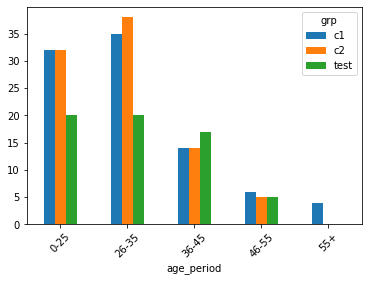

In [175]:
age_count.fillna(0, inplace=True)
age_count.set_index('age_period', inplace=True)
age_count.plot.bar(rot=45)

H0: распределение по возрасту не зависит от группы  
H1: распределение по возрасту зависит от группы

тк 55+ у нас есть только в группе с1 -мб их вынести за скобки, но попробую еще проверить и с ними

In [176]:
#pg.normality(data=selected_users, dv="age", group="grp", method="normaltest")#это просто по возрасту с 0м клиентов в c2 test и 
#p только для тестовой больше 0.05

In [177]:
selected_users_wo_55=selected_users[selected_users['age']<= 55]

In [178]:
#selected_users.head()

In [179]:
pg.normality(data=selected_users_wo_55, dv="age", group="grp", method="normaltest")

,W,pval,normal
test,3.907700,0.141727,True
c1,12.773133,0.001684,False
c2,11.681202,0.002907,False


In [180]:
selected_users['age_period_index'] = selected_users['age_period'].map({'0-25': 1, '26-35': 2, '36-45': 3, '46-55': 4, '55+': 5})

In [181]:
pg.normality(data=selected_users, dv="age_period_index", group="grp", method="normaltest")

,W,pval,normal
test,7.128374,0.028320,False
c1,15.179495,0.000506,False
c2,7.259434,0.026524,False


вроде убрал 55+ для с1 а изменились данные для нормальности тестовой 

In [182]:
pg.homoscedasticity(data=selected_users_wo_55, dv="age", group="grp")

,W,pval,equal_var
levene,0.970908,0.380253,True


In [183]:
pg.homoscedasticity(data=selected_users, dv="age_period_index", group="grp")

,W,pval,equal_var
levene,1.188926,0.306343,True


а дисперсии похожи для обоих случаев + р-значение больше 0.05 в обоих случаях

In [184]:
pg.kruskal(data=selected_users_wo_55, dv='age', between='grp')

,Source,ddof1,H,p-unc
Kruskal,grp,2,3.482293,0.175319


In [185]:
pg.kruskal(data=selected_users, dv='age_period_index', between='grp')

,Source,ddof1,H,p-unc
Kruskal,grp,2,1.585194,0.452668


медианы индексов возрастных периодов (и самого возраста) в группах могут быть равны  => различия в распределении возрастных периодов между группами не являются статистически значимыми

In [186]:
gender_count=users.groupby(['grp','gender']).agg({'uid':'count'}).reset_index()
gender_count.shape

(6, 3)

In [187]:
gender_count= pd.pivot_table(gender_count, values='uid', index='gender', columns='grp')

In [188]:
gender_count#цифры по соотношению 0 к 1 конечно впечатляющие...

grp,c1,c2,test
gender,,,
0,180,186,190
1,3959,3874,3912


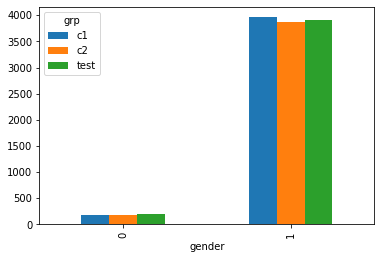

In [189]:
gender_count.plot.bar()

здесь брал общую users ибо гендер 0 не покупал премиум новыми системами оплаты в каждой из групп => нужно посмотреть по пользователям, а не клиентам  
кажется группы однородны, проверим статтестом

H0: распределение по гендеру не зависит от группы  
H1: распределение по гендеру зависит от группы

In [190]:
chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(users.gender, users.grp))
print(f"Значение статистики Хи-квадрат: {chi2_stat}")
print(f"P-значение теста: {p_val}")

Значение статистики Хи-квадрат: 0.43516327368590746
P-значение теста: 0.8044619285069371


т.к. р-значение больше 0.05, то верна гипотеза H0: распределение по полу не зависит от группы

подведем итоги:

In [191]:
selected_users.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,grp,age_period,age_period_index
20,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,1.0,1.0,12597,test,26-35,2
44,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,1.0,1.0,37817,test,0-25,1
148,891806436,32,57,0.0,Italy,"1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19",1,20,35,69,1.0,1.0,12597,test,26-35,2


In [192]:
selected_users.shape

(242, 16)

In [193]:
selected_users.groupby('grp')['uid'].count()

grp
c1      91
c2      89
test    62
Name: uid, dtype: int64

In [194]:
users.groupby('grp')['uid'].count()

grp
c1      4139
c2      4060
test    4102
Name: uid, dtype: int64

In [195]:
selected_users.country.nunique()

13

In [196]:
transactions.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
5,892426491,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597,147,autoreply_message,premium_no_trial,test
6,891558921,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100,147,left_sidebar_menu,premium_no_trial,test
12,891178380,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477,147,promo_09,premium_no_trial,test


In [197]:
transactions.payment_id.unique()

array([147,  68])

In [198]:
transactions.product_type.unique()

array(['premium_no_trial'], dtype=object)

In [199]:
print(transactions.joined_at.min(), transactions.joined_at.max())
print(transactions.paid_at.min(), transactions.paid_at.max())

2017-01-11 03:07:00 2017-10-31 23:40:00
2017-01-11 05:16:00 2017-12-11 15:23:00


объединю обработанные df

In [200]:
users_tr=selected_users.merge(transactions, how='left',on=['uid','grp','country'])
users_tr.head(3)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,...,total_revenue,grp,age_period,age_period_index,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891152790,29,769,0.0,Spain,"2,5,6",1,16,32,13,...,12597,test,26-35,2,2017-08-11 18:39:00,2017-10-11 11:29:00,12597,147,dating,premium_no_trial
1,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",1,18,24,181,...,37817,test,0-25,1,2017-10-31 14:16:00,2017-10-31 16:07:00,12597,147,popular_users_chat,premium_no_trial
2,891806436,32,57,0.0,Italy,"1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19",1,20,35,69,...,12597,test,26-35,2,2017-10-27 08:51:00,2017-10-30 17:34:00,12597,147,promo_09,premium_no_trial


In [201]:
users_tr.shape #252 потому что некоторые клиенты совершали несколько оплат

(252, 22)

In [202]:
users_tr.uid.nunique()

242

In [203]:
users_tr.country.nunique()

13

In [204]:
users_tr=users_tr[['uid','country','gender','was_premium','is_premium','grp','revenue','total_revenue','payment_id','product_type']]

In [205]:
users_tr.head()

,uid,country,gender,was_premium,is_premium,grp,revenue,total_revenue,payment_id,product_type
0,891152790,Spain,1,1.0,1.0,test,12597,12597,147,premium_no_trial
1,891589239,Italy,1,1.0,1.0,test,12597,37817,147,premium_no_trial
2,891806436,Italy,1,1.0,1.0,test,12597,12597,147,premium_no_trial
3,891882681,Belgium,1,1.0,1.0,test,12597,20410,147,premium_no_trial
4,892211106,France,1,1.0,1.0,test,4537,4537,147,premium_no_trial


т.к. мне больше не нужны даты оплаты, а интересует только общая прибыль - могу избавиться от повторных транзакций пользователей
сложив дубликаты

In [206]:
duplicates_sum = users_tr.groupby('uid')['revenue'].sum()# времянка для уплотнения revenue
users_tr = users_tr.merge(duplicates_sum, on='uid', suffixes=('', '_sum'))#временный столбец с суммой прибыли
users_tr['revenue'] = users_tr['revenue_sum']#заменил значения
users_tr = users_tr.drop(columns=['revenue_sum'])# удалил времянку, в revenue вся прибыль из дф транзакций 


In [207]:
users_tr.head()

,uid,country,gender,was_premium,is_premium,grp,revenue,total_revenue,payment_id,product_type
0,891152790,Spain,1,1.0,1.0,test,12597,12597,147,premium_no_trial
1,891589239,Italy,1,1.0,1.0,test,12597,37817,147,premium_no_trial
2,891806436,Italy,1,1.0,1.0,test,12597,12597,147,premium_no_trial
3,891882681,Belgium,1,1.0,1.0,test,12597,20410,147,premium_no_trial
4,892211106,France,1,1.0,1.0,test,4537,4537,147,premium_no_trial


In [208]:
users_tr.uid.nunique()

242

In [209]:
users_tr = users_tr.sort_values('revenue', ascending=False)#отсортировал по убыванию
users_tr = users_tr.drop_duplicates(subset='uid', keep='first')#запись о клиенте по общей выручке с него

In [210]:
users_tr.shape#теперь количество клиентов и произведенных ими оплат совпадает

(242, 10)

In [211]:
users_tr['money_question']=users_tr['total_revenue']-users_tr['revenue']

In [212]:
print (users_tr.total_revenue.sum() , users_tr.revenue.sum(), users_tr.money_question.sum()) #ошибка подготовки????

3473509 2075112 1398397


не знаю что делать с этой суммой - ниже когда считаю arpu беру же доход\всех пользователей

In [213]:
users_tr.head(3)#дф с клиентами!

,uid,country,gender,was_premium,is_premium,grp,revenue,total_revenue,payment_id,product_type,money_question
57,891178380,Spain,1,1.0,1.0,test,113477,129870,147,premium_no_trial,16393
17,892038759,United Arab Emirates,1,1.0,1.0,test,113477,123565,147,premium_no_trial,10088
196,891778551,United Arab Emirates,1,1.0,1.0,c2,81796,81796,147,premium_no_trial,0


### Вывод по подготовке данных

> В ходе подготовки работы с данными, были произведены следующие действия :  
- Удаление пустых значений в данных по пользователям и транзакицям
- Определение и выборка эскпериментальных средств оплаты - 68 и 147
- Определение времени проведения эксперимента - 2017 год
- Определение списка стран-участниц эксперимента - 13
- Определено количество уникальных участников эксперимента - 242  
из них в тестовой - 62; в контрольной 1 - 91; в контрольной 2 - 89.
- Определение ошибок дат в транзакциях с последующими корректировками
- Было принято решение по каждому пользователю, что совершал более одной оплаты за экспериментальный период
- Были проверены гипотезы о распределении клиентов - различия в распределении между группами не являются статистически значимыми.
- Было выявлено несовпадение сумм прибыли между данными о пользователях и транзакциях


###### Выборки репрезентативны; Система сплитования выстроена корректно

###  Проверяем успешность эксперимента

Так как в начале мы взяли тезис успешности как увеличение количества новых подписчиков и прибыли компании, то стоит посмотреть на количество привлеченных клиентов и их удержание в приложении, а так же посчитать средний доход с пользователя для тестовой и контрольных групп и конкретно изменение принесенной прибыли объектом исследования.  
Будем работать с метриками CR (соотношение), ARPPU(средняя прибыль с клиента).

для начала сведу обработанные данные в одну таблицу и посчитаю продуктовые метрики  
users- все пользователи  
investors - клиенты новых систем оплаты  
cr - соотношение клиент\пользователи    
avg - средний чек  
re-buy - повтор покупки премиума  
arppu - arppu  
arpu - arpu  

In [214]:
df_metrics=pd.DataFrame()
df_metrics['users'] = users.groupby('grp').uid.count()#agg({'uid': 'count'}) выдает ошибку в этой строке????
df_metrics['investors'] = users_tr.groupby('grp')['uid'].count()
df_metrics['cr']=df_metrics['investors']/df_metrics['users']
df_metrics['avg']=users_tr.groupby('grp').revenue.mean().round(2)
filtered_users_tr1 = users_tr[(users_tr['was_premium'] == 1) & (users_tr['is_premium'] == 1)]
df_metrics['re-buy']=filtered_users_tr1.groupby('grp').revenue.count() / df_metrics['investors']
df_metrics['arppu'] = users_tr.groupby('grp').revenue.sum()/df_metrics['investors']#прибыль с дф транзакций/клиентов с транзакций
df_metrics['arpu']=users.groupby('grp').total_revenue.sum()/df_metrics['users']#прибыль пользователей/пользователей

In [215]:
df_metrics

,users,investors,cr,avg,re-buy,arppu,arpu
c1,4139,91,0.021986,7269.00,0.868132,7269.000000,590.948780
c2,4060,89,0.021921,7463.17,0.898876,7463.168539,441.631773
test,4102,62,0.015115,12087.27,0.903226,12087.274194,549.264261


на первый взгляд тестовая группа приносит больше прибыли в среднем при меньшем  соотношении клиентов к пользователям, клиенты платят больше, но при этом показатель повторной покупки и средний доход на одного пользователя не то чтобы вырос

для начала проверим гипотезу о том, что количество  клиентов для тестовой и контрольной группы статистически значимо

In [216]:
users['investors'] = users['uid'].isin(users_tr['uid'])#true\false

In [217]:
users_test_c2 = users.copy()#отдельная дф

In [218]:
users_test_c2 = users_test_c2[users_test_c2['grp'] != 'c1']
users_test_c2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,grp,investors
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test,False
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test,False
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test,False
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test,False
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test,False


In [219]:
chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(users_test_c2.investors, users_test_c2.grp))
print(f"Значение статистики Хи-квадрат: {chi2_stat}")
print(f"P-значение теста: {p_val}")

Значение статистики Хи-квадрат: 4.838032141571337
P-значение теста: 0.027838645223916415


тест Хи-квадрат показывает что у нас возможна статистически значимая взаимосвязь между группами и  соотношением клиентов к пользователям

Так как сотношение клиентов к пользователям для тестовой группы ниже чем в контрольной и статистически значимо - можем судить что в плане привлечения новых клиентов эксперимент вышел ***неудачным***

Посмотрим что с доходом на одного пользователя

In [220]:
pg.normality(data=users_test_c2 , dv="total_revenue", group="grp", method="normaltest")#очень близко к нулю?

,W,pval,normal
test,8425.268030,0.0,False
c2,7524.653627,0.0,False


распределение ненормально, но посмотрим на дисперсии

In [221]:
pg.homoscedasticity(data=users_test_c2, dv="total_revenue", group="grp")

,W,pval,equal_var
levene,1.672144,0.196008,True


результаты теста на гомоскедастичность указывают на отсутствие статистически значимых различий в дисперсиях выручки между группами - можем провести ттест

In [222]:
# выборки пользователей из групп 'c2' и 'test'
c2_revenue = users_test_c2[users_test_c2.grp == 'c2'].total_revenue
test_revenue = users_test_c2[users_test_c2.grp == 'test'].total_revenue

# проведение t-теста независимых выборок
ttest_result = pg.ttest(c2_revenue, test_revenue)

In [223]:
ttest_result

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.295879,7006.960699,two-sided,0.19506,"[-270.45, 55.19]",0.028627,0.058,0.252956


т.к. p-val больше 0.05, то различия в средней выручке между группами не являются статистически значимыми,cohen-d очень мал, что означает, что даже если различия в средней выручке между группами существуют, они очень малы и не имеют практического значения, BF10 так же низкий => альтернативная гипотеза маловероятна

Так как нам не удалось доказать, что arpu_all для тестовой группы хоть и выше чем в контрольной 2 статистически значимо, то можем судить, что эксперимент вышел ***неудачным***

Посмотрим по доходу на одного клиента

In [224]:
users_tr.head(3) #дф с клиентами где в revenue записана прибыль по дф транзакций

,uid,country,gender,was_premium,is_premium,grp,revenue,total_revenue,payment_id,product_type,money_question
57,891178380,Spain,1,1.0,1.0,test,113477,129870,147,premium_no_trial,16393
17,892038759,United Arab Emirates,1,1.0,1.0,test,113477,123565,147,premium_no_trial,10088
196,891778551,United Arab Emirates,1,1.0,1.0,c2,81796,81796,147,premium_no_trial,0


In [225]:
users_tr_test_c2=users_tr.copy()

In [226]:
users_tr_test_c2=users_tr_test_c2[users_tr_test_c2['grp'] != 'c1']

In [227]:
pg.normality(data=users_tr_test_c2 , dv="revenue", group="grp", method="normaltest")

,W,pval,normal
test,99.302614,2.733451e-22,False
c2,150.341909,2.257716e-33,False


In [228]:
pg.homoscedasticity(data=users_tr_test_c2, dv="revenue", group="grp")

,W,pval,equal_var
levene,2.314694,0.130276,True


In [229]:
# выборки пользователей из групп 'c2' и 'test'
c2_revenue_2 = users_tr_test_c2[users_tr_test_c2.grp == 'c2'].total_revenue
test_revenue_2 = users_tr_test_c2[users_tr_test_c2.grp == 'test'].total_revenue

# проведение t-теста независимых выборок
ttest_result = pg.ttest(c2_revenue_2, test_revenue_2)

In [230]:
ttest_result

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.32987,80.284547,two-sided,0.022326,"[-14772.07, -1162.37]",0.432119,2.09,0.737407


результаты ттеста указывают на статистически значимые различия в доходе на одного клиента между группами

Получается, что по средней прибыли с клиента эксперимент оказался ***успешным*** 

In [231]:
#Проверим статистику повторных покупок - получились странные результаты, что то напутал

In [232]:
#users_tr_test_c2.head()

In [233]:
#users_tr_test_c2.query('is_premium == 0')

In [256]:
ndf=users.query('was_premium == 1 and is_premium == 0')
ndf.shape

(689, 15)

In [235]:
#ndf.head()

In [236]:
#transactions.head()

In [257]:
nndf=ndf.merge(transactions, how='left',on=['uid','grp','country'])

In [258]:
nndf.shape

(689, 21)

In [259]:
nndf.uid.nunique()

689

In [260]:
nndf.payment_id.value_counts()

68.0     19
147.0     8
Name: payment_id, dtype: int64

In [261]:
nndf=nndf.dropna()

In [264]:
qv_uid=nndf[nndf['total_revenue']!=nndf['revenue']]


In [268]:
spisok=qv_uid['uid'].tolist()

In [269]:
spisok

[892405224, 892393119, 891676365, 892032669, 891435993]

In [270]:
transactions[transactions['uid'].isin(spisok)]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
42,892393119,Italy,2017-10-15 00:34:00,2017-10-21 13:10:00,1807,68,none,premium_no_trial,c1
46,891676365,France,2017-10-29 20:43:00,2017-10-29 20:59:00,2717,68,none,premium_no_trial,c1
184,892032669,United States of America,2017-10-22 14:04:00,2017-10-26 14:56:00,3614,68,none,premium_no_trial,c1
343,892405224,Israel,2017-10-14 19:57:00,2017-10-15 13:08:00,6292,147,dating,premium_no_trial,c1
322,891435993,Canada,2017-03-11 21:08:00,2017-03-11 21:26:00,3549,68,none,premium_no_trial,c2


In [272]:
qv_u=users[users['uid'].isin(spisok)]

In [276]:
#qv_u.columns

In [274]:
qv_u=qv_u[['uid','coins','country','was_premium','is_premium','total_revenue','investors']]

In [275]:
qv_u

,uid,coins,country,was_premium,is_premium,total_revenue,investors
1263,892405224,0.0,Israel,1.0,0.0,8424,True
1972,892393119,0.0,Italy,1.0,0.0,3614,True
2129,891676365,10.0,France,1.0,0.0,5135,True
3305,892032669,24.0,United States of America,1.0,0.0,10803,True
370,891435993,16.0,Canada,1.0,0.0,6097,True


In [280]:
(5135-2717)/10 == (10803-3614)/24

False

In [242]:
#transactions[transactions['uid'] == 891435993]

In [243]:
#users[users['uid'] == 891435993]

In [244]:
#users_tr_test_c2.shape

In [245]:
#users_tr_test_c2['rebuy'] = ((users_tr_test_c2['was_premium'] > 0) & (users_tr_test_c2['is_premium'] > 0)).astype(int)

In [246]:
#chi2_stat, p_val, dof, expected = chi2_contingency(pd.crosstab(users_tr_test_c2.rebuy, users_tr_test_c2.grp))
#print(f"Значение статистики Хи-квадрат: {chi2_stat}") #0???
#print(f"P-значение теста: {p_val}") #1.0???

тк прибыль с клиента увеличилась - посмотрим на частоту транзакций

In [247]:
transactions.shape

(269, 9)

In [248]:
trans_test_c2=transactions[transactions['grp'] != 'c1']

In [249]:
trans_test_c2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,grp
5,892426491,United States of America,2017-10-14 10:13:00,2017-10-15 22:39:00,12597,147,autoreply_message,premium_no_trial,test
6,891558921,United States of America,2017-01-11 03:07:00,2017-10-11 09:05:00,9100,147,left_sidebar_menu,premium_no_trial,test
12,891178380,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477,147,promo_09,premium_no_trial,test
21,891312873,Italy,2017-05-11 21:22:00,2017-10-11 21:51:00,7852,147,promo_09,premium_no_trial,test
22,891071157,United States of America,2017-10-11 10:20:00,2017-10-11 16:37:00,9100,147,promo_09,premium_no_trial,test


In [250]:
trans_test_c2.shape

(169, 9)

In [251]:
u=trans_test_c2.groupby(['grp','uid'], as_index = False).paid_at.count()
u.head()

,grp,uid,paid_at
0,c2,891068079,1
1,c2,891077727,1
2,c2,891112263,1
3,c2,891136632,1
4,c2,891143379,1


In [252]:
u[u['paid_at']>1]#не густо

,grp,uid,paid_at
75,c2,892139829,3
97,c2,892435536,2
141,test,892097937,3
152,test,892339626,3


In [253]:
pg.normality(data=u, dv="paid_at", group="grp", method="normaltest")

,W,pval,normal
c2,185.139007,6.274445e-41,False
test,107.223090,5.209571e-24,False


In [254]:
pg.homoscedasticity(data=u, dv="paid_at", group="grp")

,W,pval,equal_var
levene,0.497609,0.481578,True


In [255]:
# выборки пользователей из групп 'c2' и 'test'
c2_r = u[u.grp == 'c2'].paid_at
test_r = u[u.grp == 'test'].paid_at

# проведение t-теста независимых выборок
ttest_result = pg.ttest(c2_r, test_r)
ttest_result

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.645754,96.853133,two-sided,0.519965,"[-0.13, 0.07]",0.11337,0.21,0.107949


т.к. p-val больше 0.05, то различия в количестве повторных транзакций между группами не являются статистически значимыми,cohen-d очень мал, что означает, что даже если различия в средней выручке между группами существуют, они очень малы и не имеют практического значения, BF10 так же низкий => альтернативная гипотеза маловероятна

Так как нам не удалось доказать, что увеличение повторных транзакций для тестовой группы над контрольной 2 статистически значимо, то можем судить, что эксперимент вышел ***неудачным***

### Вывод:   
###### Экперимент  не принес нам значимых улучшений

В ходе анализа данных только ***рост*** показателя средней выручки с клиента ***ARPPU*** оказался статистически ***значим***.
Показатели ***ARPU, CR*** статистически ***не улучшились***. Рост повторных транзакций ***недоказан***.  
Остался непонятным момент с работой внутриигровой валюты, возможными различиями в региональных ценах.  
Стоит пересмотреть условия акции или работу самих платежных систем - что-то в их работе может неустраивать пользователей.